In [1]:
import torch
import torch.nn as nn

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.dconv_down1 = double_conv(n_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out


Models loaded successfully!
Step 1: Segmenting pancreas...
Step 2: Extracting pancreas region...
Step 3: Classifying pancreas...


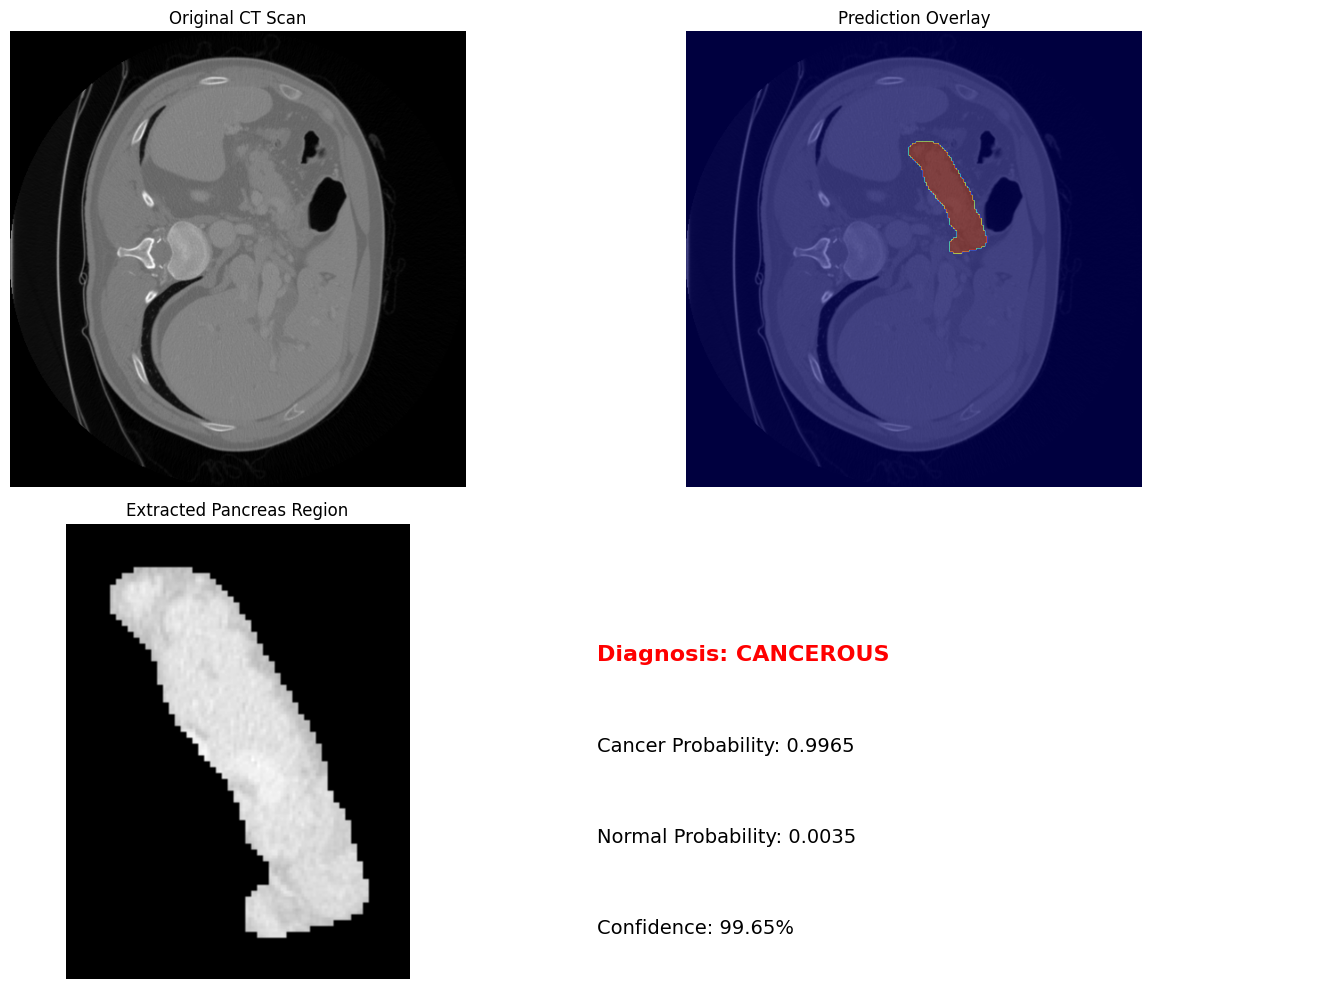


PANCREAS CANCER DETECTION RESULTS
Diagnosis: CANCEROUS
Cancer Probability: 0.9965
Normal Probability: 0.0035
Confidence: 99.65%

Final Diagnosis: CANCEROUS
Confidence: 99.65%


In [2]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from torchvision import models

class PancreasCancerDetector:
    def __init__(self, segmentation_model_path, classification_model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load segmentation model
        self.segmentation_model = UNet(n_channels=1, n_classes=1).to(self.device)
        self.segmentation_model.load_state_dict(torch.load(segmentation_model_path))
        self.segmentation_model.eval()
        
        # Load classification model 
        self.classification_model = models.resnet18(weights=None) 
        num_features = self.classification_model.fc.in_features

        
        self.classification_model.fc = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(num_features, 512),
            nn.ReLU(), 
            nn.Dropout(0.7),
            nn.Linear(512, 2)
        )

        self.classification_model.load_state_dict(torch.load(classification_model_path))
        self.classification_model = self.classification_model.to(self.device)
        self.classification_model.eval()
        
        # Define transforms
        self.seg_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        
        self.class_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        print("Models loaded successfully!")
    
    def segment_pancreas(self, image):
        """Segment pancreas from CT image"""
        # Preprocess image
        image_tensor = self.seg_transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.segmentation_model(image_tensor)
            pred_mask = (torch.sigmoid(output) > 0.5).float()
        
        return pred_mask.squeeze().cpu().numpy(), image_tensor.squeeze().cpu().numpy()
    
    def extract_pancreas_region(self, original_image, mask):
        # Convert to numpy
        original_array = np.array(original_image)
        mask_array = (mask > 0.5).astype(np.uint8)
        
        # Resize mask to match original image size
        from PIL import Image
        mask_resized = np.array(Image.fromarray(mask_array).resize(original_array.shape[::-1], Image.NEAREST))
        
        # Extract pancreas region
        pancreas_region = original_array * mask_resized
        
        # Find bounding box
        coords = np.argwhere(mask_resized > 0)
        if len(coords) > 0:
            y_min, x_min = coords.min(axis=0)
            y_max, x_max = coords.max(axis=0)
            
            # Add padding
            padding = 15
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(original_array.shape[1], x_max + padding)
            y_max = min(original_array.shape[0], y_max + padding)
            
            # Crop region
            cropped_region = pancreas_region[y_min:y_max, x_min:x_max]
            
            if cropped_region.size > 0:
                return Image.fromarray(cropped_region)
        
        return None
    
    def classify_pancreas(self, pancreas_image):
        # Preprocess for classification
        image_tensor = self.class_transform(pancreas_image).unsqueeze(0).to(self.device)
    
        with torch.no_grad():
            outputs = self.classification_model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
    
        
        cancer_prob = probabilities[0][0].item()  
        normal_prob = probabilities[0][1].item()  
        is_cancer = predicted.item() == 0  
    
        return is_cancer, cancer_prob, probabilities.cpu().numpy()[0]
    def predict(self, image_path, visualize=True):
        # Load image
        original_image = Image.open(image_path).convert('L')
    
        print("Step 1: Segmenting pancreas...")
        mask, processed_image = self.segment_pancreas(original_image)
    
        print("Step 2: Extracting pancreas region...")
        pancreas_region = self.extract_pancreas_region(original_image, mask)
    
        if pancreas_region is None:
            print("Warning: Could not extract pancreas region.")
            return None, None, None, None
    
        print("Step 3: Classifying pancreas...")
        is_cancer, cancer_prob, all_probs = self.classify_pancreas(pancreas_region)
    
        
        result = {
            'is_cancer': is_cancer,
            'cancer_probability': cancer_prob,  
            'normal_probability': all_probs[1], 
            'diagnosis': 'CANCEROUS' if is_cancer else 'NORMAL',
            'confidence': cancer_prob if is_cancer else all_probs[1]
        }
    
        if visualize:
            self.visualize_prediction(original_image, mask, pancreas_region, result)
    
        return result, original_image, mask, pancreas_region
    def visualize_prediction(self, original_image, mask, pancreas_region, result):
        """Visualize the prediction results"""
        fig, axes = plt.subplots(2, 2, figsize=(15,10))
        
        # Original image
        axes[0,0].imshow(original_image, cmap='gray')
        axes[0,0].set_title('Original CT Scan')
        axes[0,0].axis('off')
        
        # Segmentation mask
        axes[0,1].imshow(original_image, cmap='gray')
        axes[0,1].imshow(mask, cmap='jet', alpha=0.5, extent=axes[0,1].get_images()[0].get_extent())
        axes[0,1].set_title('Prediction Overlay')
        axes[0,1].axis('off')
        
        # Extracted pancreas
        axes[1,0].imshow(pancreas_region, cmap='gray')
        axes[1,0].set_title('Extracted Pancreas Region')
        axes[1,0].axis('off')
        
        # Results
        axes[1,1].text(0.1, 0.7, f"Diagnosis: {result['diagnosis']}", fontsize=16, 
                      fontweight='bold', color='red' if result['is_cancer'] else 'green')
        axes[1,1].text(0.1, 0.5, f"Cancer Probability: {result['cancer_probability']:.4f}", fontsize=14)
        axes[1,1].text(0.1, 0.3, f"Normal Probability: {result['normal_probability']:.4f}", fontsize=14)
        axes[1,1].text(0.1, 0.1, f"Confidence: {result['confidence']:.2%}", fontsize=14)
        axes[1,1].set_xlim(0, 1)
        axes[1,1].set_ylim(0, 1)
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*50)
        print("PANCREAS CANCER DETECTION RESULTS")
        print("="*50)
        print(f"Diagnosis: {result['diagnosis']}")
        print(f"Cancer Probability: {result['cancer_probability']:.4f}")
        print(f"Normal Probability: {result['normal_probability']:.4f}")
        print(f"Confidence: {result['confidence']:.2%}")
        print("="*50)

# Usage Example
def main():
    # Initialize the detector
    detector = PancreasCancerDetector(
        segmentation_model_path='/kaggle/input/models/unet_pancreas_segmentation.pth',
        classification_model_path='/kaggle/input/models/best_cancer_classifier.pth'
    )
    
    # Test on a new CT scan
    test_image_path = "/kaggle/input/testing/cancer_062.png"  
    
    try:
        result, original, mask, pancreas_region = detector.predict(test_image_path, visualize=True)
        
        if result is not None:
            print(f"\nFinal Diagnosis: {result['diagnosis']}")
            print(f"Confidence: {result['confidence']:.2%}")
        else:
            print("Could not process the image. Please try with a different CT scan.")
            
    except Exception as e:
        print(f"Error processing image: {e}")

# Batch prediction function
def batch_predict(detector, image_folder):
    """Predict on multiple images"""
    import os
    
    image_extensions = ['.png', '.jpg', '.jpeg', '.tif', '.tiff']
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) 
                  if any(f.lower().endswith(ext) for ext in image_extensions)]
    
    results = []
    for image_path in image_paths:
        print(f"\nProcessing: {os.path.basename(image_path)}")
        try:
            result, _, _, _ = detector.predict(image_path, visualize=False)
            if result is not None:
                results.append({
                    'image_name': os.path.basename(image_path),
                    'diagnosis': result['diagnosis'],
                    'cancer_probability': result['cancer_probability'],
                    'confidence': result['confidence']
                })
                print(f"Result: {result['diagnosis']} (Confidence: {result['confidence']:.2%})")
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    
    return results

if __name__ == "__main__":
    main()